## 0. Imports

In [1]:
import utils.dataset_functions as df
import utils.user_features as uf
import utils.two_towers as ttn
import pandas as pd
import torch
import numpy as np
from threading import Thread
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm as progress_bar


(Path("dataset") / "processed").mkdir(parents=True, exist_ok=True)
data_dir = Path("dataset") / "unprocessed"
data_dir.mkdir(parents=True, exist_ok=True)

## 1. Download and write locally to CSV's

In [ ]:
# Write files locally
dataset_types = ["likes", "listens", "dislikes", "unlikes", "undislikes"]
dataset = df.YambdaDataset('flat', '50m')
for dt in dataset_types:
    df.download_df(dataset=dataset, dataset_type=dt)


if not (data_dir / "embeddings.csv").exists():
    embeddings = dataset.audio_embeddings().to_pandas()
    embeddings.to_csv(data_dir / "embeddings.csv", index=False)
    del embeddings

## 2. Load Dataframes

In [2]:
# User like-dislike interactions
likes = pd.read_csv(data_dir / "likes.csv", usecols=['uid', 'timestamp', 'item_id'])
dislikes = pd.read_csv(data_dir / "dislikes.csv", usecols=['uid', 'timestamp', 'item_id'])
unlikes = pd.read_csv(data_dir / "unlikes.csv", usecols=['uid', 'timestamp', 'item_id'])
undislikes = pd.read_csv(data_dir / "dislikes.csv", usecols=['uid', 'timestamp', 'item_id'])

# If not done before
if (Path("dataset") / "processed" / "merged.csv").exists():
    user_item_data = pd.read_csv(Path("dataset") / "processed" / "merged.csv", index_col=False)
    user_item_data["normalized_embed"] = user_item_data["normalized_embed"].apply(df.parse_embedding)

else:
    # User listen interactions
    listens = pd.read_csv(data_dir / "listens.csv", index_col=False)
    listens.drop(columns=['is_organic'])

    # due to computational limitations, we constrain our dataset to users to have between 500 and 5000 timestamps.
    listens = listens.groupby('uid').filter(lambda x: 500 <= len(x) <= 5000)

    # Embeddings
    embeddings = pd.read_csv(data_dir/'embeddings.csv', usecols=['item_id', 'normalized_embed'], index_col=False)
    embeddings["normalized_embed"] = embeddings["normalized_embed"].apply(df.parse_embedding)

    # Merge the song embeddings and user listens dataset 
    user_item_data = pd.merge(listens, embeddings, on='item_id', how='inner')
    
    
    # save memory
    del listens
    del embeddings

    # Determine the labels under different conditions using this function.
    user_item_data[["labels", "net_interactions"]] = user_item_data.apply(
    uf.get_song_label_and_user_interacton,
    axis=1,
    args=(likes, user_item_data, unlikes, dislikes, undislikes),
    result_type="expand") 

    # Save our processed dataset.
    user_item_data.to_csv(Path("dataset") / "processed" / "merged.csv", index=False)

user_item_data

,uid,timestamp,item_id,is_organic,played_ratio_pct,track_length_seconds,normalized_embed
0,100,39420,8326270,0,100,170,"[-0.169998115, -0.0959603293, 0.0354052303, -0..."
1,100,39420,1441281,0,100,105,"[-0.11168661, -0.06717089, -0.01324262, -0.075..."
2,100,39625,286361,0,100,185,"[-0.08362152, 0.01492759, 0.04177505, -0.07362..."
3,100,40110,732449,0,100,240,"[-0.09272503, 0.00863106, 0.00500664, -0.07165..."
4,100,40360,3397170,0,46,130,"[0.00739911, 0.02237171, -0.05895943, -0.04705..."
...,...,...,...,...,...,...,...
9606652,999900,25757935,7156502,0,100,155,"[-0.03618009, -0.01209565, -0.04070508, 0.0260..."
9606653,999900,25758105,3117997,0,51,195,"[-0.13640163, 0.09070778, -0.11365859, -0.0977..."
9606654,999900,25777330,9224219,1,0,295,"[-0.17506402, -0.07690737, -0.09771042, -0.106..."
9606655,999900,25777360,8192914,1,15,155,"[-0.0344837197, 0.0172222336, 0.00892607541, 0..."


## 3. Create and save user features
We do this in train/val/test splits

In [ ]:

users = user_item_data['uid'].unique()

# It is HIGHLY recommended to use more than 1 thread per set
# You can split the data equally over threads like so:

todo_users = [u for u in users if not (Path("dataset")/ "processed" / "users"/ f"{u}.pt").exists()]
num_threads = 14
k, m = divmod(len(todo_users), num_threads)
user_split = [todo_users[i*k + min(i, m) : (i+1)*k + min(i+1, m)] for i in range(num_threads)]



# Multithread it to make it somewhat time managable
t1 = Thread(target=uf.extract_and_save_features, args=(user_split[0], Path("dataset")/ "processed" / "users", user_item_data, likes, unlikes, dislikes, undislikes))
t2 = Thread(target=uf.extract_and_save_features, args=(user_split[1], Path("dataset")/ "processed" / "users", user_item_data, likes, unlikes, dislikes, undislikes))
t3 = Thread(target=uf.extract_and_save_features, args=(user_split[2], Path("dataset")/ "processed" / "users", user_item_data, likes, unlikes, dislikes, undislikes))

t1.start()
t2.start()
t3.start()


t1.join()
t2.join()
t3.join()


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [5]:
# free up memory, we don't need this anymore
del user_item_data 
del likes
del dislikes
del unlikes
del undislikes

### 3.1: merge the seperate user files

In [25]:
files = Path("dataset") / "processed" / "users"
train = []
val = []
test = []


train_feats = []
train_ids = []
train_embeds = []
train_labels = []
train_interactions = []

val_feats = []
val_ids = []
val_embeds = []
val_labels = []
val_interactions = []

test_feats = []
test_ids = []
test_embeds = []
test_labels = []
test_interactions = []

files = list(files.glob("*.pt"))

for file in progress_bar(files, desc="Processing users"):
    data = torch.load(file, map_location="cpu")

    feats = data['user_feats']         # shape: [N, F]
    user_ids = data['user_ids']        # shape: [N]
    embeds = data['song_embeds']       # shape: [N, E]
    labels = data['labels']            # shape: [N, L]
    interactions = data['interactions'] # shape: [N]

    N = feats.shape[0]

    # ---- Split indices ----
    train_end = int(N * 0.70)
    val_end   = int(N * 0.85)

    # ---- Slice per user ----
    feats_train = feats[:train_end]
    feats_val   = feats[train_end:val_end]
    feats_test  = feats[val_end:]

    ids_train = user_ids[:train_end]
    ids_val   = user_ids[train_end:val_end]
    ids_test  = user_ids[val_end:]

    embeds_train = embeds[:train_end]
    embeds_val   = embeds[train_end:val_end]
    embeds_test  = embeds[val_end:]

    labels_train = labels[:train_end]
    labels_val   = labels[train_end:val_end]
    labels_test  = labels[val_end:]

    inter_train = interactions[:train_end]
    inter_val   = interactions[train_end:val_end]
    inter_test  = interactions[val_end:]

    # ---- Append to global lists ----
    train_feats.append(feats_train)
    train_ids.append(ids_train)
    train_embeds.append(embeds_train)
    train_labels.append(labels_train)
    train_interactions.append(inter_train)

    val_feats.append(feats_val)
    val_ids.append(ids_val)
    val_embeds.append(embeds_val)
    val_labels.append(labels_val)
    val_interactions.append(inter_val)

    test_feats.append(feats_test)
    test_ids.append(ids_test)
    test_embeds.append(embeds_test)
    test_labels.append(labels_test)
    test_interactions.append(inter_test)

# ---- Final merge ----
train = {
    "user_feats": torch.cat(train_feats, dim=0),
    "user_ids": torch.cat(train_ids, dim=0),
    "song_embeds": torch.cat(train_embeds, dim=0),
    "labels": torch.cat(train_labels, dim=0),
    "interactions": torch.cat(train_interactions, dim=0),
}

val = {
    "user_feats": torch.cat(val_feats, dim=0),
    "user_ids": torch.cat(val_ids, dim=0),
    "song_embeds": torch.cat(val_embeds, dim=0),
    "labels": torch.cat(val_labels, dim=0),
    "interactions": torch.cat(val_interactions, dim=0),
}

test = {
    "user_feats": torch.cat(test_feats, dim=0),
    "user_ids": torch.cat(test_ids, dim=0),
    "song_embeds": torch.cat(test_embeds, dim=0),
    "labels": torch.cat(test_labels, dim=0),
    "interactions": torch.cat(test_interactions, dim=0),
}

print("Train size:", train["user_feats"].shape[0])
print("Val size:  ", val["user_feats"].shape[0])
print("Test size: ", test["user_feats"].shape[0])

torch.save(train, Path("dataset") / "processed" / "train.pt")
torch.save(val, Path("dataset") / "processed" / "val.pt")
torch.save(test, Path("dataset") / "processed" / "test.pt")

Processing users:   0%|          | 0/4457 [00:00<?, ?it/s]

Train size: 6660158
Val size:   1427629
Test size:  1429730


In [31]:
train_set = df.load_tensor_dataloader("subset", Path("dataset")/"processed", batch_size=64)
for user_feats, song_embeds, labels, interactions in train_set:
    print(user_feats.shape)
    print(song_embeds.shape)
    print(labels.shape)
    print(interactions.shape)
    break

torch.Size([64, 5])
torch.Size([64, 128])
torch.Size([64])
torch.Size([64])


## 4. Training the model

### 4.1 set the parameters

In [ ]:
import utils.dataset_functions as df
import utils.user_features as uf
import utils.two_towers as ttn
import pandas as pd
import ast
import torch
import numpy as np
from threading import Thread
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm as progress_bar


(Path("dataset") / "processed").mkdir(parents=True, exist_ok=True)
data_dir = Path("dataset") / "unprocessed"
data_dir.mkdir(parents=True, exist_ok=True)
# Input dimensions
user_dim        = 5 #+ 129  # user_features + label specific features
item_dim        = 128
aug_dim         = 32

# Dimensions of the tower FFN
hidden_dim      = 64
embed_dim       = 32

# lambda1 for loss_u & lambda2 for loss_V
lambda1         = 1
lambda2         = 1

# Training
num_epochs      = 50
learning_rate   = 1e-3
batch_size      = 128
patience        = 5
device='cuda' if torch.cuda.is_available() else 'cpu'
print("Training models on:", device)

Training models on: cuda


### 4.2 Training our models

Epoch: [3/50]


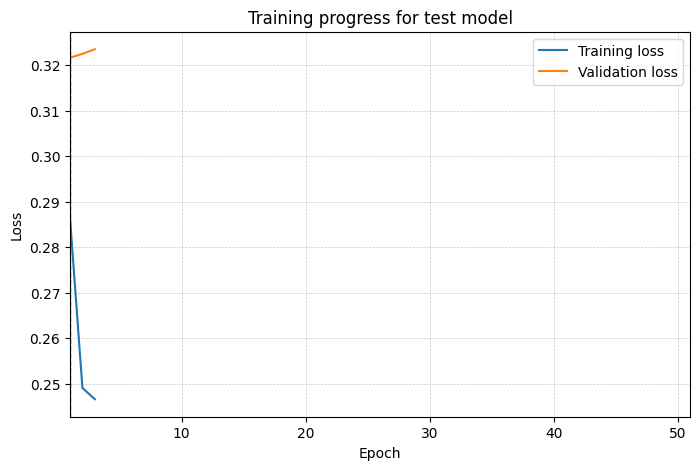

KeyboardInterrupt: 

In [ ]:
models = ["interactions_model", "multiple_listens_model", "pct_100_model", "pct_80_model"]

for label_id, model_name in enumerate(models):
    train_set = df.load_tensor_dataloader("train", Path("dataset")/"processed", batch_size, label_id)
    val_set = df.load_tensor_dataloader("val", Path("dataset")/"processed", batch_size, label_id)


    model = ttn.DualAugmentedTwoTower(model_name, user_dim, item_dim, hidden_dim, aug_dim)
    optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)
    ttn.train_model(model, train_set, val_set, optimiser, patience, num_epochs=num_epochs, device=device)

